# CASL Fuel assembly 2B

# Import modules

In [1]:
import openmc
import openmc.mgxs as mgxs

import numpy as np
import matplotlib.pyplot as plt

# Add location of OpenMC XS executable, setup ENDF xs path

In [2]:
import os

# Add path to OpenMC binary
# os.environ['PATH'] += r':/path/to/openmc/bin'
os.environ['PATH'] += r':/Users/jean.ragusa/repo/openmc/local/bin'

# Add location of OpenMC xs data
%env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/endfb-viii.0-hdf5/cross_sections.xml

env: OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/endfb-viii.0-hdf5/cross_sections.xml


# Start model

In [3]:
model = openmc.Model()

# Define Materials

In [4]:
uo2 = openmc.Material(name='uo2')

uo2.add_nuclide('U234', 6.11864E-06, 'ao')
uo2.add_nuclide('U235', 7.18132E-04, 'ao')
uo2.add_nuclide('U236', 3.29861E-06, 'ao')
uo2.add_nuclide('U238', 2.21546E-02, 'ao')
uo2.add_nuclide('O16', 4.57642E-02, 'ao')

uo2.set_density('g/cm3', 10.257 )

uo2.temperature = 600

In [5]:
zirconium = openmc.Material(name="zirconium")

zirconium.add_nuclide('Zr90', 2.18865E-02, 'ao')
zirconium.add_nuclide('Zr91', 4.77292E-03, 'ao')
zirconium.add_nuclide('Zr92', 7.29551E-03, 'ao')
zirconium.add_nuclide('Zr94', 7.39335E-03, 'ao')
zirconium.add_nuclide('Zr96', 1.19110E-03, 'ao')
zirconium.add_nuclide('Sn112',4.68066E-06, 'ao')
zirconium.add_nuclide('Sn114', 3.18478E-06, 'ao')
zirconium.add_nuclide('Sn115', 1.64064E-06, 'ao')
zirconium.add_nuclide('Sn116', 7.01616E-05, 'ao')
zirconium.add_nuclide('Sn117', 3.70592E-05, 'ao')
zirconium.add_nuclide('Sn118', 1.16872E-04, 'ao')
zirconium.add_nuclide('Sn119', 4.14504E-05, 'ao')
zirconium.add_nuclide('Sn120', 1.57212E-04, 'ao')
zirconium.add_nuclide('Sn122', 2.23417E-05, 'ao')
zirconium.add_nuclide('Sn124', 2.79392E-05, 'ao')
zirconium.add_nuclide('Fe54', 8.68307E-06, 'ao')
zirconium.add_nuclide('Fe56', 1.36306E-04, 'ao')
zirconium.add_nuclide('Fe57', 3.14789E-06, 'ao')
zirconium.add_nuclide('Fe58', 4.18926E-07, 'ao')
zirconium.add_nuclide('Cr50', 3.30121E-06, 'ao')
zirconium.add_nuclide('Cr52', 6.36606E-05, 'ao')
zirconium.add_nuclide('Cr53', 7.21860E-06, 'ao')
zirconium.add_nuclide('Cr54', 1.79686E-06, 'ao')
zirconium.add_nuclide('Hf174', 3.54138E-09, 'ao')
zirconium.add_nuclide('Hf176', 1.16423E-07, 'ao')
zirconium.add_nuclide('Hf177', 4.11686E-07, 'ao')
zirconium.add_nuclide('Hf178', 6.03806E-07, 'ao')
zirconium.add_nuclide('Hf179', 3.01460E-07, 'ao')
zirconium.add_nuclide('Hf180', 7.76449E-07, 'ao')

zirconium.set_density('g/cm3',  6.56)

zirconium.temperature = 600

In [6]:
water = openmc.Material(name="water")

water.add_nuclide('H1',4.96224E-02, 'ao')
water.add_nuclide('O16', 2.48112E-02, 'ao')
water.add_nuclide('B10', 1.07070E-05, 'ao')
water.add_nuclide('B11', 4.30971E-05, 'ao')

water.add_s_alpha_beta('c_H_in_H2O')

water.set_density('g/cm3', 0.661)

water.temperature = 600

In [7]:
helium = openmc.Material(name="helium")

helium.add_nuclide('He4',1, 'ao')

helium.set_density('g/cm3', 0.178E-03 )

helium.temperature = 600

### do not do this here because of cloning later on

In [8]:
# model.materials = openmc.Materials([uo2, zirconium, water,helium]) 

# print(model.materials)

# Defining individiual cells

In [9]:
pitch = 1.26

### Planes used to define cells

In [10]:
left   = openmc.XPlane(-pitch/2, boundary_type='transmission')
right  = openmc.XPlane( pitch/2, boundary_type='transmission')
bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
top    = openmc.YPlane( pitch/2, boundary_type='transmission')

### Create fuel pin: fuel, clad, water

In [11]:
def pin_cell_universe(family):
    fuel_outer_radius = openmc.ZCylinder(r=0.4096)
    gap_inner_radius  = openmc.ZCylinder(r=0.418)
    clad_outer_radius = openmc.ZCylinder(r=0.475)

    fuel_region  = -fuel_outer_radius
    gap_region   = +fuel_outer_radius & -gap_inner_radius
    clad_region  = +gap_inner_radius  & -clad_outer_radius
    water_region = +clad_outer_radius & +left & -right & +bottom & -top

    fuel = openmc.Cell(name=family+'-fuel')
    fuel.region = fuel_region
    new_fuel = uo2.clone()
    fuel.fill = new_fuel

    gap = openmc.Cell(name=family+'-gap')
    gap.region = gap_region
    gap.fill = helium     

    clad = openmc.Cell(name=family+'-clad')
    clad.fill = zirconium
    clad.region = clad_region

    moderator = openmc.Cell(name=family+'-moderator')
    moderator.fill = water
    moderator.region = water_region 

    return openmc.Universe(name=family+'-pin_univ', cells=(fuel, clad, moderator,gap)), new_fuel

### Create guide tube: water, clad, water

In [12]:
gt_inner_radius = openmc.ZCylinder(r=0.561)
gt_outer_radius = openmc.ZCylinder(r=0.602)

gt_water_in_region  = -gt_inner_radius
gt_clad_region      = +gt_inner_radius & -gt_outer_radius
gt_water_out_region = +gt_outer_radius & +left & -right & +bottom & -top

gt_water_in = openmc.Cell(name='gt-water-in')
gt_water_in.fill = water
gt_water_in.region = gt_water_in_region

gt_clad = openmc.Cell(name='gt-clad')
gt_clad.fill = zirconium
gt_clad.region = gt_clad_region

gt_water_out = openmc.Cell(name='gt-water-out')
gt_water_out.fill = water
gt_water_out.region = gt_water_out_region 

gt_univ = openmc.Universe(name='gt_univ', cells=(gt_water_in, gt_clad, gt_water_out))

### Create instrumentation tube: water, clad, water

In [13]:
it_inner_radius = openmc.ZCylinder(r=0.559)
it_outer_radius = openmc.ZCylinder(r=0.605)

it_water_in_region  = -it_inner_radius
it_clad_region      = +it_inner_radius & -it_outer_radius
it_water_out_region = +it_outer_radius & +left & -right & +bottom & -top

it_water_in = openmc.Cell(name='it-water-in')
it_water_in.fill = water
it_water_in.region = it_water_in_region

it_clad = openmc.Cell(name='it-clad')
it_clad.fill = zirconium
it_clad.region = it_clad_region

it_water_out = openmc.Cell(name='it-water-out')
it_water_out.fill = water
it_water_out.region = it_water_out_region 

it_univ = openmc.Universe(name='it_univ', cells=(it_water_in, it_clad, it_water_out))

## Read fuel assembly layout

In [14]:
import csv
from collections import Counter

def read_csv_to_2d_array(file_path):
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        data = [row for row in reader]
    return np.asarray(data)

def count_frequencies(data):
    flattened_data = [item for row in data for item in row]  # Flatten 2D array into a 1D list
    cell_frequencies = Counter(flattened_data)
    print("cell name frequency:")
    total = 0
    for key, value in cell_frequencies.items():
        print(f'"{key}": {value}')
        total += value
    print("total: ",total)

def fuel_keys(data, exclude_keys=["gt","it"]):
    """
    Return a list of keys after excluding any keys found in 'exclude_keys'.
    
    Parameters:
        keys (list): List of keys to filter.
        exclude_keys (list): List of keys that should be excluded from the result.
    
    Returns:
        list: A new list with the keys not present in the exclude_keys list.
    """
    flattened_data = [item for row in data for item in row]  # Flatten 2D array into a 1D list
    cell_frequencies = Counter(flattened_data)
    keys = list(cell_frequencies.keys())
    return [key for key in keys if key not in exclude_keys]


In [15]:
file_path = 'FA_cell_names_7_families.csv'  # Change this to the actual path of your CSV file
file_path = 'FA_cell_names_1_family.csv'    # Change this to the actual path of your CSV file

# read cell names
FA_cell_names = read_csv_to_2d_array(file_path)
# print statistics
count_frequencies(FA_cell_names)

# check
if FA_cell_names.shape[0] != FA_cell_names.shape[1]:
    raise Exception('array of cell names is not square')
# number of fuel assembly per dimension
Nassy = FA_cell_names.shape[0] # size of the assembly 

# get fuel cell names
fuel_names = fuel_keys(FA_cell_names)
print("\nfuel names=",fuel_names)

cell name frequency:
"fu": 264
"gt": 24
"it": 1
total:  289

fuel names= ['fu']


## Create several fuel pin universes to handle the multiple fuel-MGXS to be generated

In [16]:
# list of material that will be used
material_list = [ helium, zirconium, water ]

pin_univ_clones = {}
for fuel_name in fuel_names:
    pin_univ_clones[fuel_name], new_fuel = pin_cell_universe(fuel_name)
    material_list.append(new_fuel)

In [17]:
model.materials = openmc.Materials(material_list) 

print(model.materials)

[Material
	ID             =	4
	Name           =	helium
	Temperature    =	600
	Density        =	0.000178 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	He4            =	1            [ao]
, Material
	ID             =	2
	Name           =	zirconium
	Temperature    =	600
	Density        =	6.56 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Zr90           =	0.0218865    [ao]
	Zr91           =	0.00477292   [ao]
	Zr92           =	0.00729551   [ao]
	Zr94           =	0.00739335   [ao]
	Zr96           =	0.0011911    [ao]
	Sn112          =	4.68066e-06  [ao]
	Sn114          =	3.18478e-06  [ao]
	Sn115          =	1.64064e-06  [ao]
	Sn116          =	7.01616e-05  [ao]
	Sn117          =	3.70592e-05  [ao]
	Sn118          =	0.000116872  [ao]
	Sn119          =	4.14504e-05  [ao]
	Sn120          =	0.000157212  [ao]
	Sn122          =	2.23417e-05  [ao]
	Sn124          =	2.79392e-05  [ao]
	Fe54           =	8.6830

In [18]:
uo2

Material
	ID             =	1
	Name           =	uo2
	Temperature    =	600
	Density        =	10.257 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	U234           =	6.11864e-06  [ao]
	U235           =	0.000718132  [ao]
	U236           =	3.29861e-06  [ao]
	U238           =	0.0221546    [ao]
	O16            =	0.0457642    [ao]

In [19]:
pin_univ_clones

{'fu': Universe
 	ID             =	3
 	Name           =	fu-pin_univ
 	Geom           =	CSG
 	Cells          =	[7, 9, 10, 8]}

# Lattice geometry

In [20]:
FA_lat = openmc.RectLattice()

FA_lat.pitch = (pitch, pitch)

FA_half_width = Nassy * pitch / 2

FA_lat.lower_left = (-FA_half_width, -FA_half_width)

### Fill in cells of fuel assembly

### caveat. user supplied bool in the cell below :  `one_eighth`

In [21]:
# either 1/8 or 1/4 of FA
one_eighth = True

In [22]:
# ndarray of type openmc Universe    
FA_univ_layout = np.empty((Nassy, Nassy), dtype = openmc.universe.Universe)

for i in range(Nassy):
    for j in range(Nassy):
        cellname = FA_cell_names[i,j]
        if cellname == 'gt':
            FA_univ_layout[i,j] = gt_univ
        elif cellname == 'it':
            FA_univ_layout[i,j] = it_univ
        elif cellname in fuel_names:
            FA_univ_layout[i,j] = pin_univ_clones[cellname]            
        else:
            mesg = 'i={},j={},cell-name {} not recognized'.format(i, j, cellname)
            raise ValueError(mesg)

# assign universes
FA_lat.universes = FA_univ_layout

# create cell that will contain the lattice
moderator_outside_cell = openmc.Cell( name = 'water_outside', fill = water )

FA_lat.outer = openmc.Universe( name='outer', cells = [moderator_outside_cell] )

# height
FA_height = 10.
# half of the inter fuel assembly water gap (half the spacing in between FAs)
dr2 = 0.04 


min_x = openmc.XPlane(x0= 0.               , boundary_type='reflective')
max_x = openmc.XPlane(x0= FA_half_width+dr2, boundary_type='reflective')
min_y = openmc.YPlane(y0= 0.               , boundary_type='reflective')
max_y = openmc.YPlane(y0= FA_half_width+dr2, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-FA_height/2      , boundary_type='reflective')
max_z = openmc.ZPlane(z0= FA_height/2      , boundary_type='reflective')
xy    = openmc.Plane(-1., 1.               , boundary_type='reflective')


# define root universe
root_cell = openmc.Cell( name = 'root cell', fill = FA_lat )

if one_eighth:
    root_cell.region = -max_x & +min_y & -xy
else:
    root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

### Plot

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

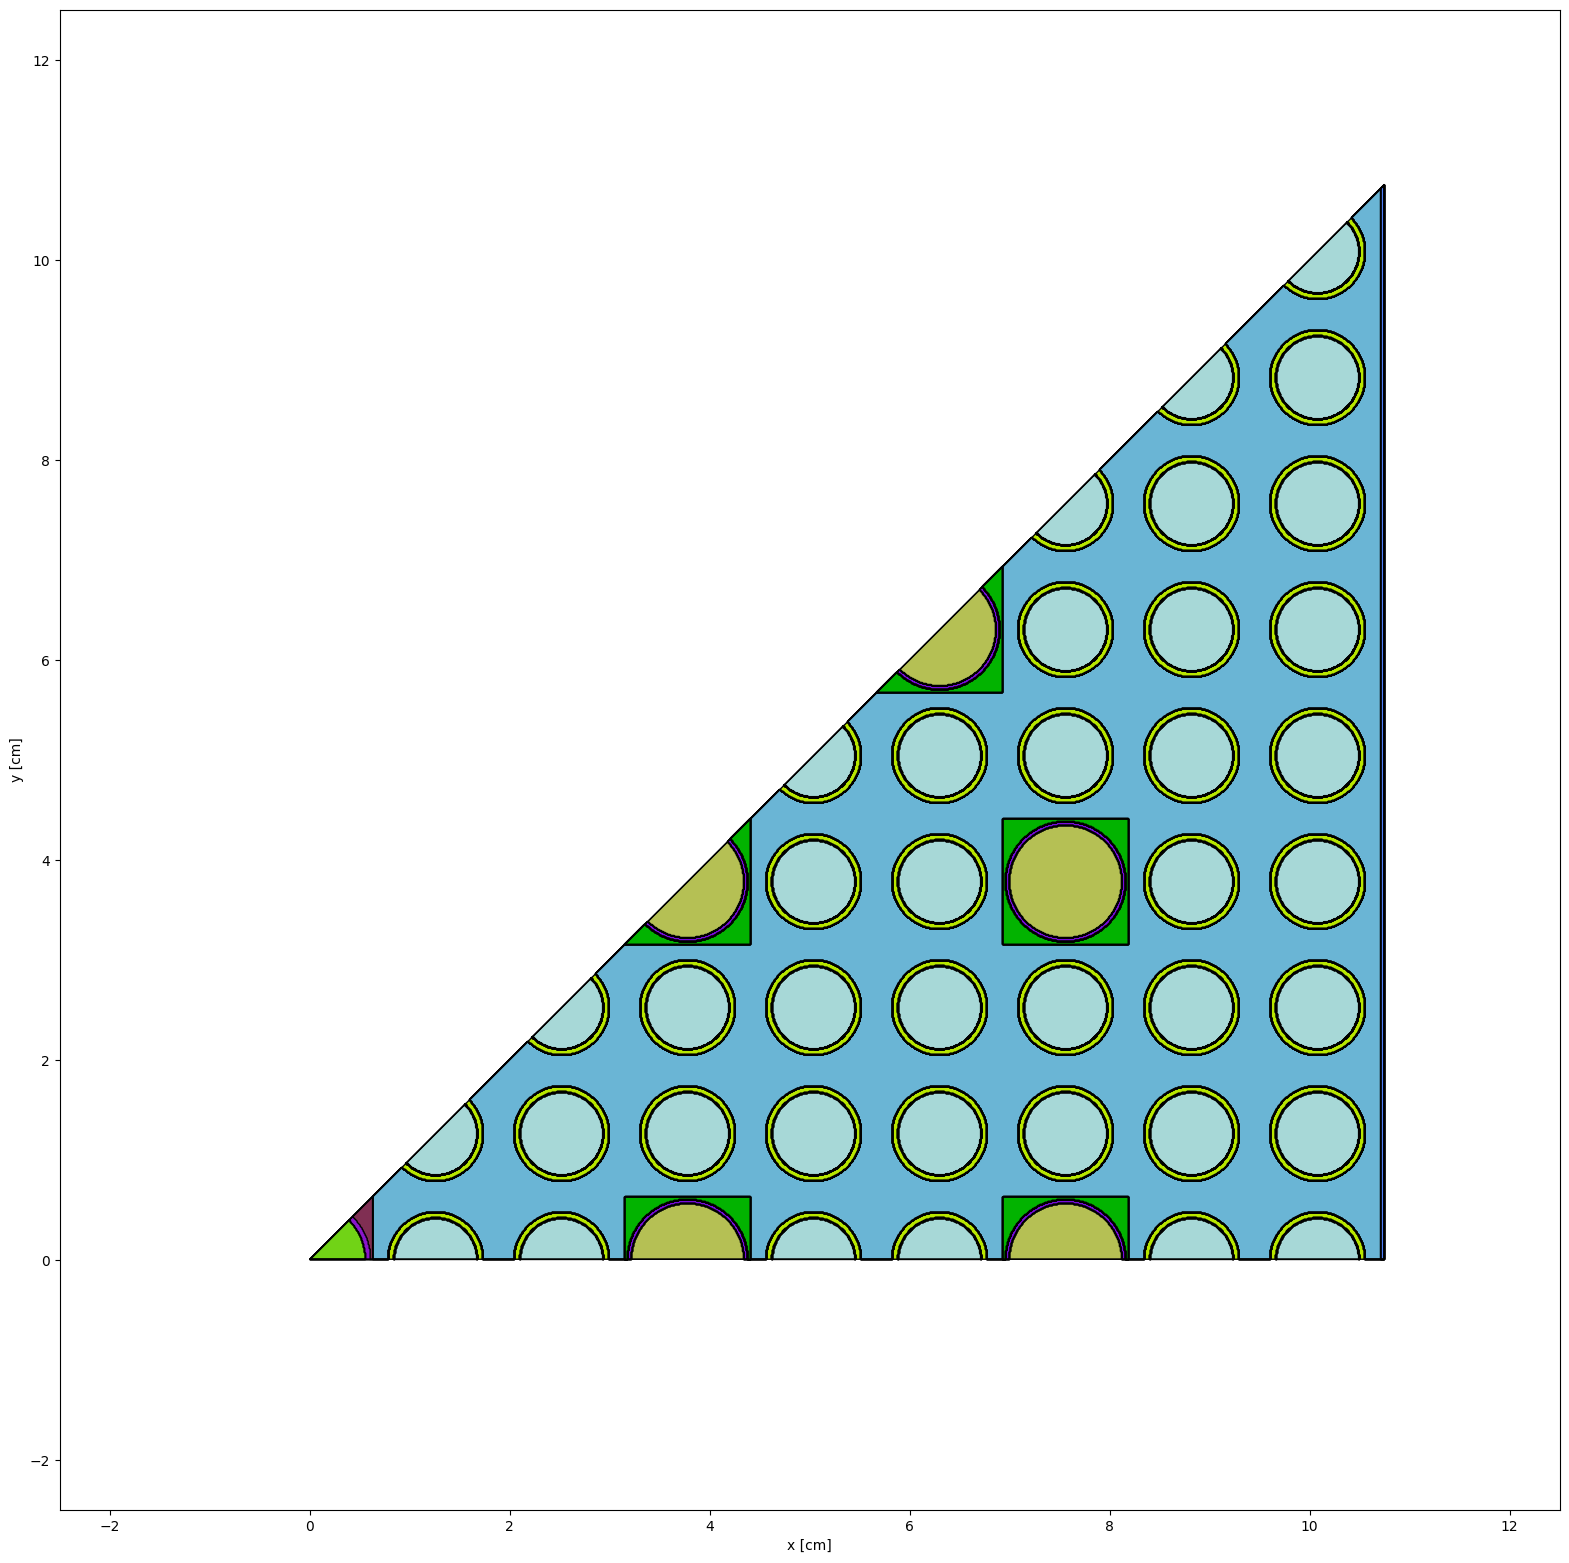

In [23]:
root_cell.plot(origin=(5,5,0), pixels=(1500,1500), width=(15,15),color_by='cell',outline=True)

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

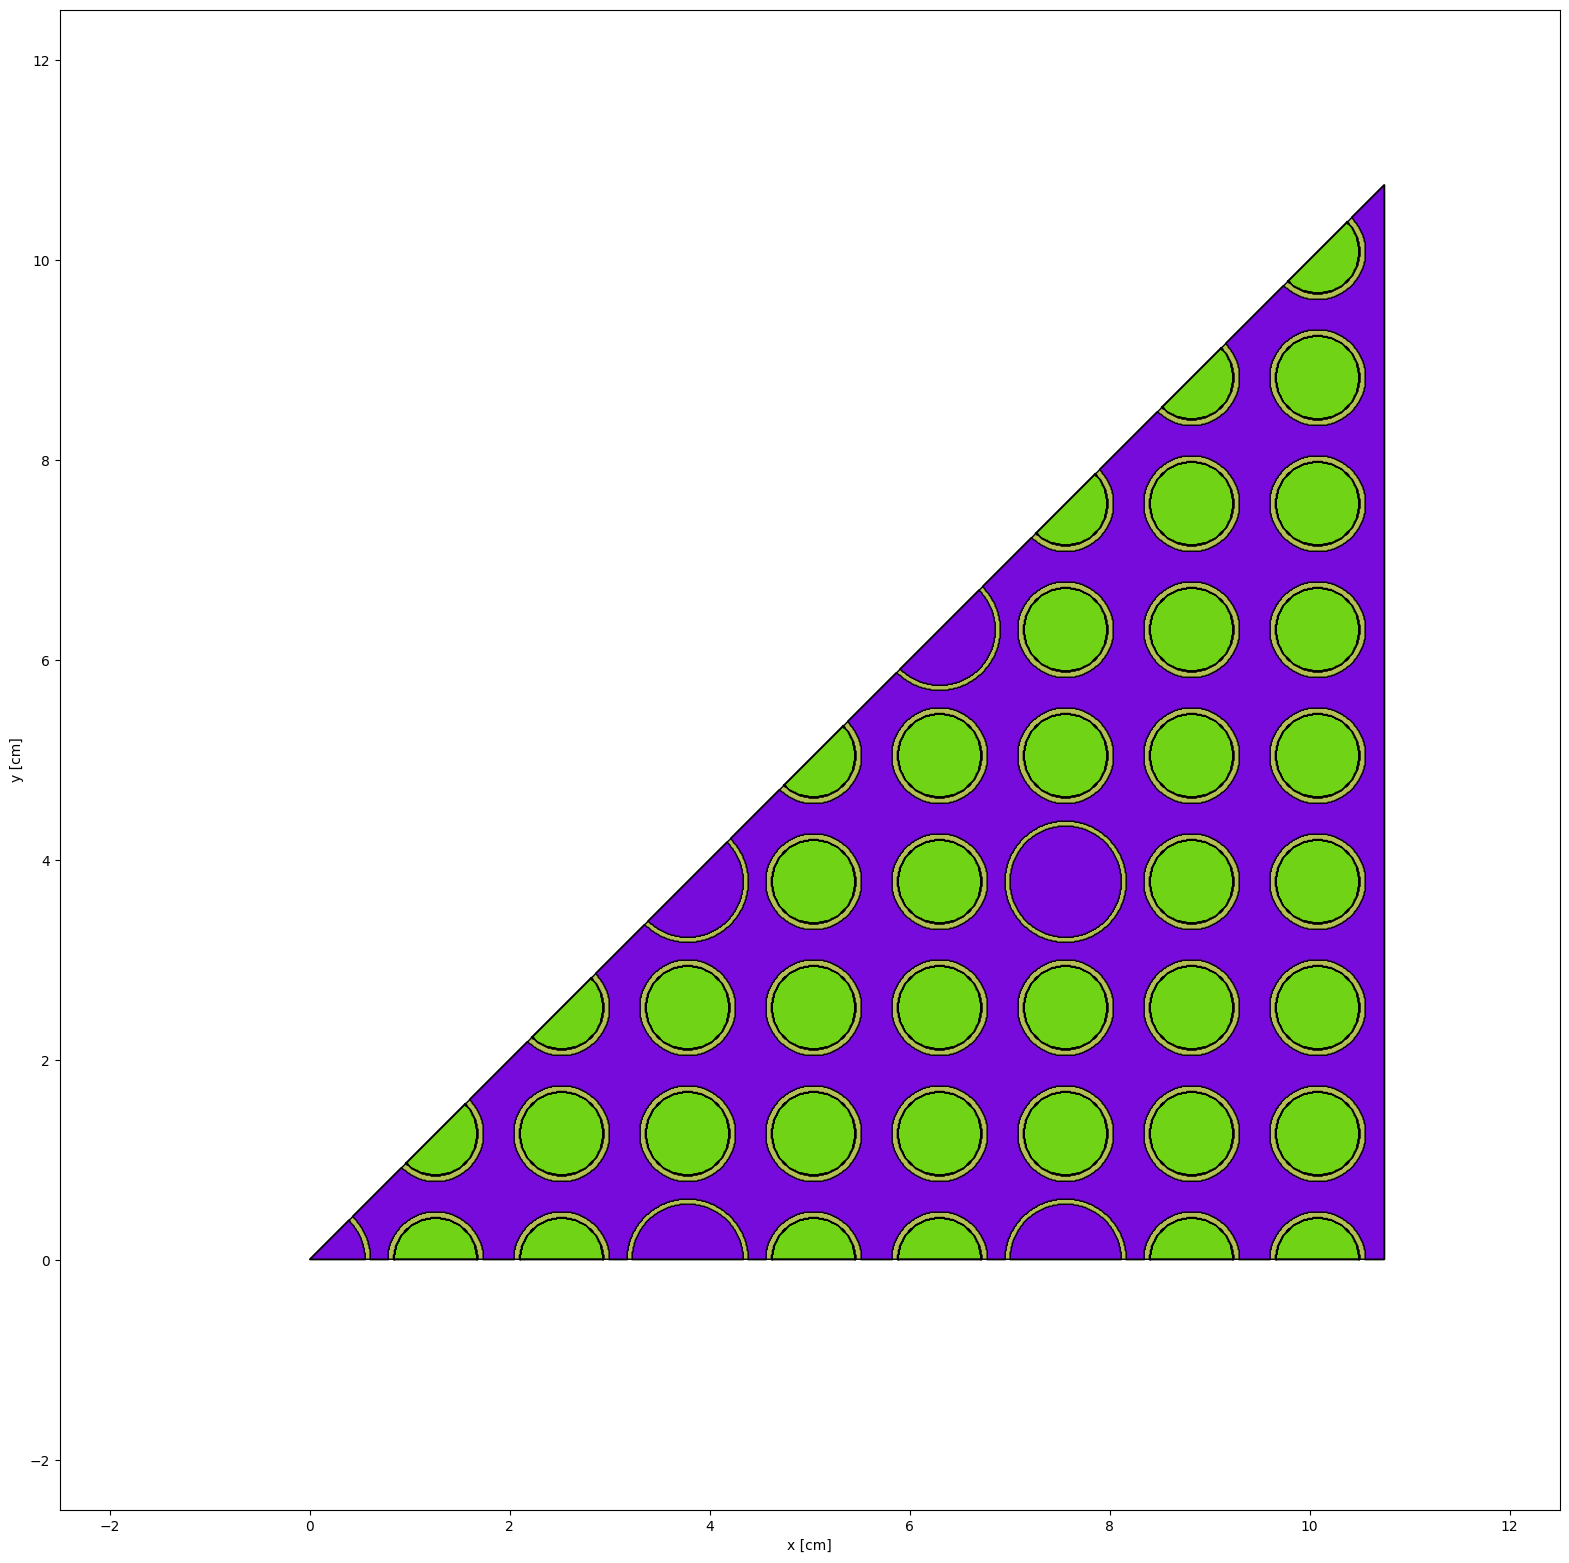

In [24]:
root_cell.plot(origin=(5,5,0), pixels=(1500,1500), width=(15,15),color_by='material', outline=True)

In [25]:
model.geometry.root_universe = openmc.Universe(name = 'root universe', cells=[root_cell])

### Source

In [26]:
model.geometry.bounding_box

BoundingBox(lower_left=(-inf, 0.0, -inf), upper_right=(10.75, inf, inf))

In [27]:
bbox = openmc.BoundingBox(lower_left  = [0., 0., -FA_height/2], \
                          upper_right = [FA_half_width, FA_half_width, FA_height/2])
print(bbox)

BoundingBox(lower_left=(0.0, 0.0, -5.0), upper_right=(10.71, 10.71, 5.0))


In [28]:
uniform_dist = openmc.stats.Box(bbox.lower_left, bbox.upper_right, only_fissionable=True)

source = openmc.IndependentSource(space=uniform_dist)

###  Settings

### caveat: destination folder supplied here

In [29]:
# instantitate settings object
settings = openmc.Settings()

# add source
settings.source = source

# add additional parameters
settings.batches =  50
settings.inactive = 20
settings.particles = 5000
# settings.keff_trigger = {'type':'std_dev','threshold':0.00010}
# settings.trigger_active = True
# settings.trigger_max_batches = 50000
# settings.output = {'tallies':True}
settings.temperature['method'] = 'interpolation'

my_path = './mgxs_casl_2b'
settings.output = {'tallies': True, 'path':my_path}

model.settings = settings

In [30]:
# check if folder exists
import pathlib
path = pathlib.Path(my_path)
path.mkdir(parents = True, exist_ok = True)

### Choose energy group

In [31]:
my_path

'./mgxs_casl_2b'

In [32]:
# egroup_name = 'XMAS-172'
egroup_name = 'SHEM-361'
egroup = openmc.mgxs.GROUP_STRUCTURES[egroup_name]

### Create MGXS tallies for mgxs directory

In [33]:
tally_power = openmc.Tally(name='power')

# Instantiate a tally Mesh
mesh = openmc.RegularMesh()
mesh._dimension = [17, 17]
mesh._lower_left = [-FA_half_width, -FA_half_width]
mesh._upper_right = [FA_half_width,FA_half_width]

# Instantiate tally Filter
mesh_filter = openmc.MeshFilter(mesh)

tally_power.scores = ['fission', 'nu-fission', 'kappa-fission']
tally_power.filters = [mesh_filter]

tallies = openmc.Tallies([tally_power])
# model.tallies=tallies

In [34]:
tally_by_cells = True

In [35]:
pn = 7
    
mgxs_lib = openmc.mgxs.Library(model.geometry)
groups = openmc.mgxs.EnergyGroups(egroup)

mgxs_lib.energy_groups = groups
mgxs_lib.scatter_format = "legendre"
mgxs_lib.mgxs_types = ['total', 'absorption', 'nu-fission', 'fission' ,'chi', \
                       'consistent nu-scatter matrix', 'multiplicity matrix','kappa-fission']

mgxs_lib.legendre_order = pn
if pn == 0:
    mgxs_lib.correction = None

mgxs_lib.by_nuclide = False

if tally_by_cells:
    # Specify a "cell" domain type for the cross section tally filters
    mgxs_lib.domain_type = 'cell'
    # Specify the cell domains over which to compute multi-group cross sections
    mgxs_lib.domains = model.geometry.get_all_material_cells().values()
else:
    mgxs_lib.domain_type = 'universe'
    mgxs_lib.domains = model.geometry.get_all_universes().values()
    
# Construct all tallies needed for the multi-group cross section library
mgxs_lib.build_library()
mgxs_lib.check_library_for_openmc_mgxs()

# tallies = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies, merge=True)

model.tallies = tallies

/Users/jean.ragusa/anaconda3/lib/python3.11/site-packages/openmc/mgxs/library.py:401: RuntimeWarning: The P0 correction will be ignored since the scattering order 7 is greater than zero
  warn(msg, RuntimeWarning)


### Export model

In [36]:
## model.export_to_model_xml('casl_2B.xml')

### Run OpenMC model

In [37]:
# trick to make several runs work with jupyter
try:
    sp 
    print('sp found')
    sp.close()
except NameError:
    print('sp NOT found')

sp NOT found


In [38]:
statepoint_filename = model.run()

/Users/jean.ragusa/anaconda3/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=401.
  warn(msg, IDWarning)
/Users/jean.ragusa/anaconda3/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=3.
  warn(msg, IDWarning)
/Users/jean.ragusa/anaconda3/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=11.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [39]:
# Load the last statepoint file
sp = openmc.StatePoint(statepoint_filename)

In [40]:
xs_names = [] 
for cell in (mgxs_lib.domains):
    print(cell.name)
    xs_names.append(cell.name)

print(mgxs_lib.domains)

fu-fuel
fu-clad
fu-moderator
fu-gap
gt-water-in
gt-clad
gt-water-out
it-water-in
it-clad
it-water-out
water_outside
[Cell
	ID             =	7
	Name           =	fu-fuel
	Fill           =	Material 5
	Region         =	-9
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	9
	Name           =	fu-clad
	Fill           =	Material 2
	Region         =	(10 -11)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	10
	Name           =	fu-moderator
	Fill           =	Material 3
	Region         =	(11 1 -2 3 -4)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	8
	Name           =	fu-gap
	Fill           =	Material 4
	Region         =	(9 -10)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	1
	Name           =	gt-water-in
	Fill           =	Ma

In [41]:
model.geometry.get_all_material_cells().values()

dict_values([Cell
	ID             =	7
	Name           =	fu-fuel
	Fill           =	Material 5
	Region         =	-9
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	9
	Name           =	fu-clad
	Fill           =	Material 2
	Region         =	(10 -11)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	10
	Name           =	fu-moderator
	Fill           =	Material 3
	Region         =	(11 1 -2 3 -4)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	8
	Name           =	fu-gap
	Fill           =	Material 4
	Region         =	(9 -10)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	1
	Name           =	gt-water-in
	Fill           =	Material 3
	Region         =	-5
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volu

In [42]:
model.geometry.get_all_materials().values()

dict_values([Material
	ID             =	5
	Name           =	uo2
	Temperature    =	600
	Density        =	10.257 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	U234           =	6.11864e-06  [ao]
	U235           =	0.000718132  [ao]
	U236           =	3.29861e-06  [ao]
	U238           =	0.0221546    [ao]
	O16            =	0.0457642    [ao]
, Material
	ID             =	2
	Name           =	zirconium
	Temperature    =	600
	Density        =	6.56 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Zr90           =	0.0218865    [ao]
	Zr91           =	0.00477292   [ao]
	Zr92           =	0.00729551   [ao]
	Zr94           =	0.00739335   [ao]
	Zr96           =	0.0011911    [ao]
	Sn112          =	4.68066e-06  [ao]
	Sn114          =	3.18478e-06  [ao]
	Sn115          =	1.64064e-06  [ao]
	Sn116          =	7.01616e-05  [ao]
	Sn117          =	3.70592e-05  [ao]
	Sn118          =	0.000116872  [ao]
	Sn119          =	

In [43]:
model.geometry.get_all_universes().values()

dict_values([Universe
	ID             =	6
	Name           =	root universe
	Geom           =	CSG
	Cells          =	[12]
, Universe
	ID             =	3
	Name           =	fu-pin_univ
	Geom           =	CSG
	Cells          =	[7, 9, 10, 8]
, Universe
	ID             =	1
	Name           =	gt_univ
	Geom           =	CSG
	Cells          =	[1, 2, 3]
, Universe
	ID             =	2
	Name           =	it_univ
	Geom           =	CSG
	Cells          =	[4, 5, 6]
, Universe
	ID             =	5
	Name           =	outer
	Geom           =	CSG
	Cells          =	[11]
])

In [44]:
if one_eighth:
    txt = 'one_eighth'
else:
    txt = 'one_quarter'

In [45]:
mgxs_lib.load_from_statepoint(sp)
    
h5_file_path = my_path + f'/mgxs_{txt}_{egroup_name}.h5'
print(h5_file_path)

# below, no need for xs_type = 'macro' as it is the default
# mgxs_lib.create_mg_library(xsdata_names=all_cell_order).export_to_hdf5(h5_file_path)
mgxs_lib.create_mg_library(xsdata_names=xs_names).export_to_hdf5(h5_file_path)

./mgxs_casl_2b/mgxs_one_eighth_SHEM-361.h5


## power outputs

In [46]:
!pip install prettytable

In [47]:
from prettytable import PrettyTable

In [48]:
sp.tallies_present

True

In [49]:
computed_power_tallies = sp.get_tally()

In [50]:
print(computed_power_tallies)
print(type(computed_power_tallies))

Tally
	ID             =	1
	Name           =	power
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['fission', 'nu-fission', 'kappa-fission']
	Estimator      =	tracklength
	Multiply dens. =	True
<class 'openmc.tallies.Tally'>


In [51]:
computed_power_tallies.scores

['fission', 'nu-fission', 'kappa-fission']

In [52]:
# computed_power_tallies.get_score_index(score='nu-fission')
power_tally_values = computed_power_tallies.get_values()
print(power_tally_values.shape)

pin_power_file_path = my_path + f'/pinpow_{txt}_{egroup_name}.npy'
np.save(pin_power_file_path, power_tally_values)

(289, 1, 3)


In [53]:
for score_id in range(3):
    # get name of the score
    score = computed_power_tallies.scores[score_id]
    print('score = ',score)
    # extract + shape the data
    vals = power_tally_values[:,0,score_id].reshape(17,17)
    vals = vals[8:,8:]
    
    dd = np.copy(vals)

    # multiply axis of symeetry by 2 for power display
    dd[0,:] *= 2
    dd[np.diag_indices_from(dd)] *= 2

    dd = np.flip(dd,axis=0)

    table = PrettyTable()

    n_list = [str(n) for n in range(1, 10)]
    table.field_names = n_list

    # Convert ndarray to list of lists
    data_list = dd.tolist()

    for row in data_list:
        # Format each value to 2 decimal places
        formatted_row = [f"{x:.6g}" for x in row]
        table.add_row(formatted_row)

    print(table)

score =  fission
+---+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
| 1 |     2     |     3     |     4     |     5     |     6     |     7     |     8     |     9     |
+---+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
| 0 |     0     |     0     |     0     |     0     |     0     |     0     |     0     | 0.0142434 |
| 0 |     0     |     0     |     0     |     0     |     0     |     0     | 0.0137005 | 0.0138442 |
| 0 |     0     |     0     |     0     |     0     |     0     | 0.0143569 | 0.0140021 |  0.013587 |
| 0 |     0     |     0     |     0     |     0     |     0     | 0.0148143 | 0.0139931 | 0.0136116 |
| 0 |     0     |     0     |     0     | 0.0149227 | 0.0152652 | 0.0151069 | 0.0144419 | 0.0138904 |
| 0 |     0     |     0     |     0     |  0.015361 |  0.015065 |     0     | 0.0146759 | 0.0143411 |
| 0 |     0     |  0.014525 | 0.0154826 | 0.0148505 | 0.0148357 |

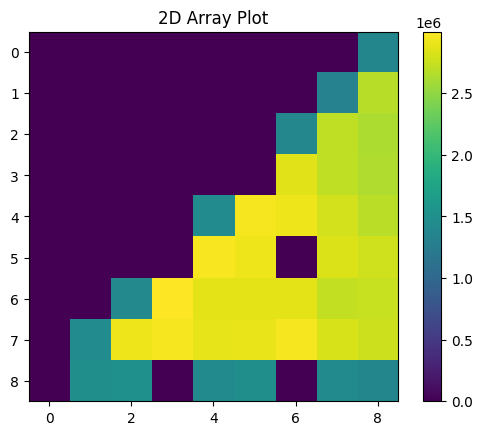

In [54]:
plt.figure()
plt.imshow(np.flip(vals,axis=0), cmap='viridis')  # You can change the colormap if desired
plt.title('2D Array Plot')
plt.colorbar()  # Adds a colorbar to show the scale
plt.show()